In [1]:
import pickle 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import numpy.linalg as la
import matplotlib.ticker as ticker

In [39]:
# load the data from csv and add column names
df = pd.read_csv('raw_2018/flow_FX_1538755200.csv', header=None)
df.columns = ['midpoint', 'ask','bid']
# b1 and b2
df_b1 = pd.read_csv('raw_2018/B1_FX_1538755200.csv', header=None)
df_b2t = pd.read_csv('raw_2018/B2t_FX_1538755200.csv', header=None)
# convert to numpy array
b1 = df_b1.values
b2t = df_b2t.values
b2 = b2t.T
exrates = df.values

In [40]:
currencies = ['AUD', 'BRL', 'CAD', 'CHF', 'CNY', 'DKK', 'EUR', 'GBP', 'HKD',
       'INR', 'JPY', 'KRW', 'MXN', 'MYR', 'NOK', 'NZD', 'PLN', 'RUB',
       'SEK', 'SGD', 'THB', 'TRY', 'TWD', 'USD', 'ZAR']

##### Create a smaller dataset for better visibility

In [41]:
n0 = b1.shape[0]
n1 = b1.shape[1]
np.random.seed(0)
perm = np.random.permutation(np.arange(n0))
to_removed_nodes = perm[0:int(n0*0.3)]

# remove the currenries based on the to_removed_nodes
currencies_less_nodes = []
for i in range(len(currencies)):
    if i not in to_removed_nodes:
        currencies_less_nodes.append(currencies[i])
        
# find the removed edge ids based on the incidence matrix 
removed_edge_ids = []
# first remove the rows from b1 
b1 = np.delete(b1, to_removed_nodes, axis=0)
# then remove the columns in b1 which have less than two nonzeros 
to_remove_ids = np.where(np.count_nonzero(b1, axis=0) < 2)[0]
b1 = np.delete(b1, to_remove_ids, axis=1)

exrates = np.delete(exrates, to_remove_ids, axis=0)
# check the number of nonzeros per column
# np.count_nonzero(b1, axis=0)
# remove the rows of b2 corresponding to the removed columns of b1
b2 = np.delete(b2, to_remove_ids, axis=0)
# remove the columns of b2 with number of nonzeros less than 3
to_remove_ids = np.where(np.count_nonzero(b2, axis=0) < 3)[0]
b2 = np.delete(b2, to_remove_ids, axis=1)
assert (b1@b2).all() == 0

n1 = b1.shape[1]
np.random.seed(0)
random_perm = np.random.permutation(np.arange(n1))
to_remove_ids = random_perm[:int(n1*0.5)]
b1 = np.delete(b1, to_remove_ids, axis=1)

exrates = np.delete(exrates, to_remove_ids, axis=0)
# remove the rows of b2 corresponding to the removed columns of b1
b2 = np.delete(b2, to_remove_ids, axis=0)
# remove the columns of b2 with number of nonzeros less than 3
to_remove_ids = np.where(np.count_nonzero(b2, axis=0) < 3)[0]
b2 = np.delete(b2, to_remove_ids, axis=1)
assert (b1@b2).all() == 0

In [42]:
L1 = b1.T@b1 + b2@b2.T
L1_down = b1.T@b1
L1_up = b2@b2.T

eigen-decomposition


In [43]:
eigvals, eigvecs = np.linalg.eigh(L1)
total_var = []
total_div = []
total_curl = []
num_eigemodes = int(1*len(eigvals))
for i in range(num_eigemodes):
    total_var.append(eigvecs[:, i].T@L1@eigvecs[:, i])
    total_div.append(eigvecs[:, i].T@L1_down@eigvecs[:, i])
    total_curl.append(eigvecs[:, i].T@L1_up@eigvecs[:, i])

harm_eflow = np.where(np.array(total_var) <= 1e-4)[0]
grad_eflow = np.where(np.array(total_div) > 1e-4)[0]
curl_eflow = np.where(np.array(total_curl) >= 1e-3)[0]
harm_eigvects = eigvecs[:, harm_eflow]
grad_eigvects = eigvecs[:, grad_eflow]
curl_eigvects = eigvecs[:, curl_eflow]
harm_eigvals = eigvals[harm_eflow]
grad_eigvals = eigvals[grad_eflow]
curl_eigvals = eigvals[curl_eflow]

Create a simplicial complex

In [44]:
# from b1 and b2 write the nodes and edges and triangles 
# the nodes are the row indices of b1
nodes = np.arange(b1.shape[0])
# the edges are the column indices of b1
edges = np.arange(b1.shape[1])
# edge lists can be found as the nonzero entries of each column of b1 
edge_list = [(np.nonzero(b1[:,i])[0][0], np.nonzero(b1[:,i])[0][1]) for i in range(b1.shape[1])]
# the triangles are the column indices of b2
triangles = np.arange(b2.shape[1])

In [45]:
# create the graph from the edge list
import networkx as nx
# G = nx.DiGraph()
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(edge_list)


In [46]:
train_ids = np.array([ 5., 40., 11., 64., 23., 49., 63., 55., 69., 20., 42., 41., 25., 65.,
          6., 46., 28., 12., 61., 33., 43., 26., 38., 35., 37., 73., 21., 70.,
         32., 51., 76., 17., 72.,  0., 18., 39., 47., 74.])
train_ids = train_ids.astype(int)
test_ids = np.array([50., 30., 57., 62., 45., 68., 71.,  7.,  3., 56., 54., 36., 19., 13.,
          1., 31.,  4., 44., 27.,  2., 22., 29.,  9., 59., 16., 58., 60., 15.,
         75., 34., 14., 66., 53., 52., 10., 48., 67., 24.,  8.])
test_ids = test_ids.astype(int)

In [47]:
# access the edges from edge list based on the train_ids
train_edges = [edge_list[i] for i in train_ids]
test_edges = [edge_list[i] for i in test_ids]

position of node labels

In [48]:
n0_reduced = len(nodes)
angle = []
angle_dict = {}
for i, node in zip(range(n0_reduced),nodes):
    theta = 2.0*np.pi*i/n0_reduced
    angle.append((np.cos(theta),np.sin(theta)))
    angle_dict[node] = theta
pos = {}
for node_i, node in enumerate(nodes):
    pos[node] = angle[node_i]

Visualize the SC

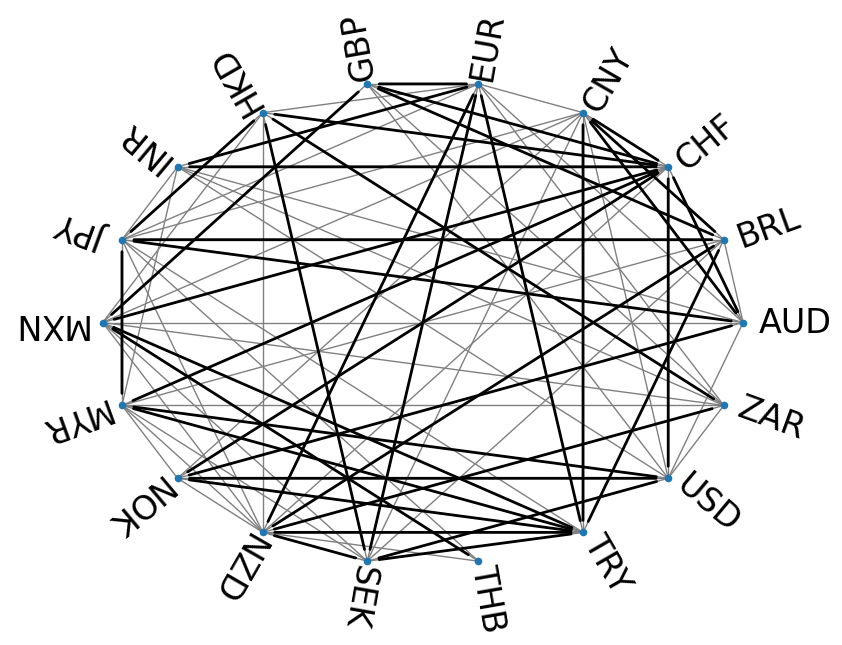

In [51]:
# view the graph
fig, ax = plt.subplots(figsize=(10,7.5))
nx.draw_circular(G, with_labels=False, edge_color='grey', node_size = 20 ,arrowsize=20)
nx.draw_networkx_edges(G, pos=nx.circular_layout(G), edgelist=test_edges, edge_color='k', width=2.0, arrows=True)
# add the currenries as node labels 
labels = {}
for i in range(len(currencies_less_nodes)):
    labels[i] = currencies_less_nodes[i]
    
description = nx.draw_networkx_labels(G,pos,labels=labels, font_size=24)
r = fig.canvas.get_renderer()
trans = plt.gca().transData.inverted()
for node, t in description.items():
    bb = t.get_window_extent(renderer=r)
    bbdata = bb.transformed(trans)
    radius = 1.05+bbdata.width/2.
    position = (radius*np.cos(angle_dict[node]),radius* np.sin(angle_dict[node]))
    t.set_position(position)
    t.set_rotation(angle_dict[node]*360.0/(2.0*np.pi))
    t.set_clip_on(False)

### drawing function 

In [52]:
def drawing_forex(y, cmap=plt.cm.viridis, label=False):
    fig, ax = plt.subplots(dpi=300, figsize=(4,2.5))
    cmap=cmap
    if label:
        nx.draw_circular(G, with_labels=False, edge_color='grey', edgelist=[], node_size=5, width=0.5)
        nx.draw_networkx_labels(G, pos=nx.circular_layout(G), labels=labels, font_size=10)
    else:
        nx.draw_circular(G, with_labels=False, edge_color='grey', edgelist=[], node_size=5, width=0.5)
    nx.draw_networkx_edges(G, pos=nx.circular_layout(G), edgelist=test_edges, width=1.5, edge_color=y[test_ids], edge_cmap=cmap, edge_vmin=y.min(), edge_vmax=y.max(),)
    nx.draw_networkx_edges(G, pos=nx.circular_layout(G), style='dashed', edgelist=train_edges, width=0.5, edge_color=y[train_ids], edge_cmap=cmap, edge_vmin=y.min(), edge_vmax=y.max(),alpha=0.5)

    
    return fig, ax, 

In [53]:
y_groundtruth = exrates[:,1]

In [54]:
import matplotlib.ticker

class OOMFormatter(matplotlib.ticker.ScalarFormatter):
    def __init__(self, order=0, fformat="%1.1f", offset=True, mathText=False):
        self.oom = order
        self.fformat = fformat
        matplotlib.ticker.ScalarFormatter.__init__(self,useOffset=offset,useMathText=mathText)
    def _set_order_of_magnitude(self):
        self.orderOfMagnitude = self.oom
    def _set_format(self, vmin=None, vmax=None):
        self.format = self.fformat
        if self._useMathText:
             self.format = r'$\mathdefault{%s}$' % self.format

## Matern kernel

learned parameters 

In [55]:
noise, mu, mu_down, mu_up, kappa, kappa_down, kappa_up, h, h_down, h_up, scale, constant = 0.00010074544115923345, 5.0093982281396165e-05, 0.010119953192770481, 2.241278648376465, 0.6931471824645996, 1.7896642684936523, 0.020662890747189522, 5.0094033213099465e-05, 5.009428024291992, 0.08287765830755234, 4.118685722351074, 0.0001306680787820369

building kernels

In [56]:
k0 = np.power(2*mu/kappa/kappa + harm_eigvals, -mu)
k0[:] = mu 
k1 = np.power(2*mu_down/kappa_down/kappa_down + grad_eigvals, -mu_down) 
k2 = np.power(2*mu_up/kappa_up/kappa_up + curl_eigvals, -mu_up) 

K0 = harm_eigvects * k0 @ harm_eigvects.T
K1 = grad_eigvects * k1 @ grad_eigvects.T
K2 = curl_eigvects * k2 @ curl_eigvects.T
K = scale*(h*K0+ h_down*K1+ h_up*K2 )
variance = np.diag(K)
vmax = variance.max()
vmin = variance.min()
if np.isclose(vmin, vmax):
    vmin = 0.0

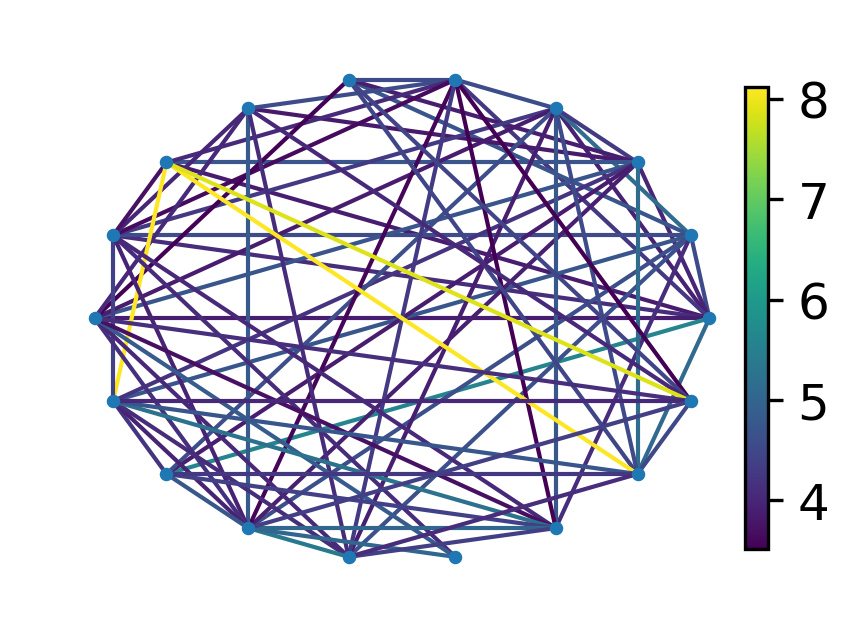

In [58]:
# create a list of colors from the diagonal of the kernel matrix
fig, ax = plt.subplots(dpi=300, figsize=(4,2.5))
cmap=plt.cm.viridis
# draw the graph with the colors
nx.draw_circular(G, ax=ax, edge_color=variance, with_labels=False, cmap=cmap, vmin=vmin, vmax=vmax, node_size=5, width=1, font_size=10, )
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
# plot the colorbar
cbar = plt.colorbar(sm, ax=ax, shrink=0.8)
cax = cbar.ax  # get the ax of the colorbar
pos = cax.get_position()  # get the original position
cax.set_position([pos.x0*0.92, pos.y0, pos.width * 0.8, pos.height])  # set a new position
cax.set_frame_on(True)
cbar.ax.tick_params(labelsize=12)
tick_locator = ticker.MaxNLocator(nbins=5)
cbar.locator = tick_locator
cbar.update_ticks()
plt.show()

# draw the mean and var of matern kernel 

In [59]:
mean = np.load('../../results/forex/pred_mean.npy', allow_pickle=True)
var = np.load('../../results/forex/pred_var.npy', allow_pickle=True)

True data

/tmp/ipykernel_2289992/167837315.py:9: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos=nx.circular_layout(G), edgelist=test_edges, width=1.5, edge_color=y[test_ids], edge_cmap=cmap, edge_vmin=y.min(), edge_vmax=y.max(),)
/tmp/ipykernel_2289992/167837315.py:10: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos=nx.circular_layout(G), style='dashed', edgelist=train_edges, width=0.5, edge_color=y[train_ids], edge_cmap=cmap, edge_vmin=y.min(), edge_vmax=y.max(),alpha=0.5)


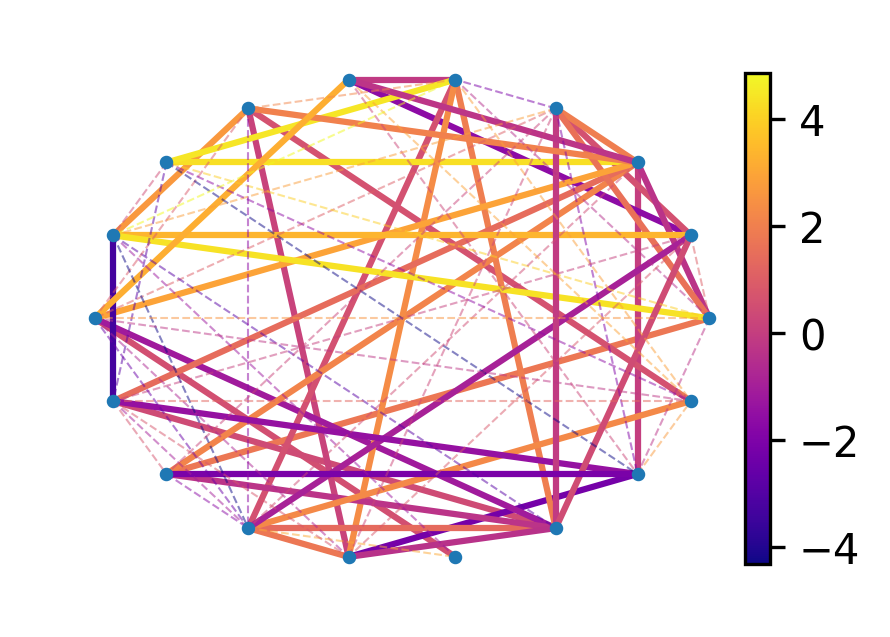

In [61]:
cmap=plt.cm.plasma
fig, ax = drawing_forex(y_groundtruth, cmap, label=False)
# nx.draw_networkx_labels(G, pos=nx.circular_layout(G), labels=labels, font_size=20)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=y_groundtruth.min(), vmax=y_groundtruth.max()))
# plot the colorbar
cbar = plt.colorbar(sm, ax=ax, shrink=0.85)
cax = cbar.ax  # get the ax of the colorbar
pos = cax.get_position()  # get the original position
cax.set_position([pos.x0*0.92, pos.y0, pos.width * 0.8, pos.height])  # set a new position
cax.set_frame_on(True)
cbar.ax.tick_params(labelsize=10)

predicted

/tmp/ipykernel_2289992/167837315.py:9: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos=nx.circular_layout(G), edgelist=test_edges, width=1.5, edge_color=y[test_ids], edge_cmap=cmap, edge_vmin=y.min(), edge_vmax=y.max(),)
/tmp/ipykernel_2289992/167837315.py:10: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos=nx.circular_layout(G), style='dashed', edgelist=train_edges, width=0.5, edge_color=y[train_ids], edge_cmap=cmap, edge_vmin=y.min(), edge_vmax=y.max(),alpha=0.5)


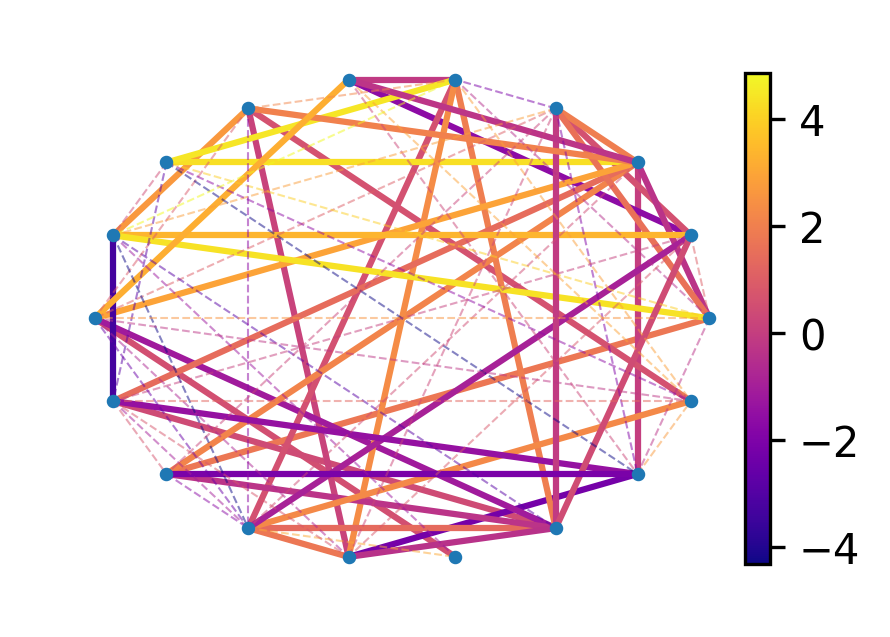

In [62]:
cmap=plt.cm.plasma
fig, ax = drawing_forex(mean, cmap)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=mean.min(), vmax=mean.max()))
# plot the colorbar
cbar = plt.colorbar(sm, ax=ax, shrink=0.85)
cax = cbar.ax  # get the ax of the colorbar
pos = cax.get_position()  # get the original position
cax.set_position([pos.x0*0.92, pos.y0, pos.width * 0.8, pos.height])  # set a new position
cax.set_frame_on(True)
cbar.ax.tick_params(labelsize=10)

variance

In [63]:
import matplotlib.ticker as ticker
from matplotlib.ticker import FuncFormatter
def format_ticks(value, tick_number):
    return r'$%.1f$' % (value * 1e2)

/tmp/ipykernel_2289992/167837315.py:9: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos=nx.circular_layout(G), edgelist=test_edges, width=1.5, edge_color=y[test_ids], edge_cmap=cmap, edge_vmin=y.min(), edge_vmax=y.max(),)
/tmp/ipykernel_2289992/167837315.py:10: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos=nx.circular_layout(G), style='dashed', edgelist=train_edges, width=0.5, edge_color=y[train_ids], edge_cmap=cmap, edge_vmin=y.min(), edge_vmax=y.max(),alpha=0.5)


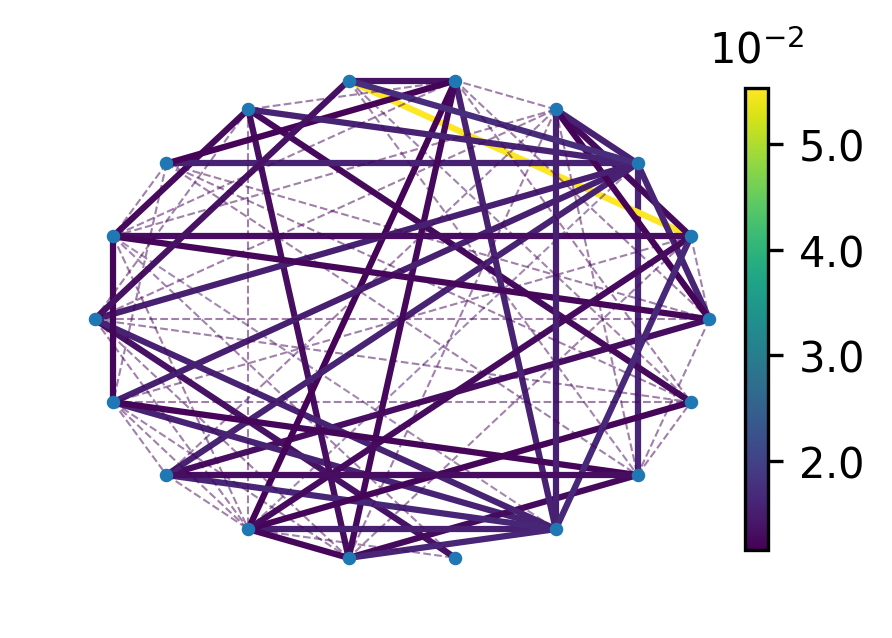

In [64]:

cmap=plt.cm.viridis
# var = np.sqrt(var)
std = np.sqrt(var)
fig, ax = drawing_forex(std, cmap)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=std.min(), vmax=std.max()))
# plot the colorbar
cbar = plt.colorbar(sm, ax=ax, spacing='uniform', format= ticker.LogFormatterSciNotation(labelOnlyBase=False), shrink=0.8 )

# Apply the formatter to the colorbar
cbar.formatter = FuncFormatter(format_ticks)
cbar.update_ticks()
cbar.ax.set_title(r'$10^{-2}$', fontdict={'fontsize': 10, 'fontweight': 'medium'})
cbar.ax.tick_params(labelsize=10)

cax = cbar.ax  # get the ax of the colorbar
pos = cax.get_position()  # get the original position
cax.set_position([pos.x0*0.92, pos.y0, pos.width * 0.8, pos.height])  # set a new position
cax.set_frame_on(True)


Line graph results - matern

In [65]:
lg_pred_mean = np.load('../../results/forex/linegraph_pred_mean.npy', allow_pickle=True)

/tmp/ipykernel_2289992/167837315.py:9: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos=nx.circular_layout(G), edgelist=test_edges, width=1.5, edge_color=y[test_ids], edge_cmap=cmap, edge_vmin=y.min(), edge_vmax=y.max(),)
/tmp/ipykernel_2289992/167837315.py:10: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos=nx.circular_layout(G), style='dashed', edgelist=train_edges, width=0.5, edge_color=y[train_ids], edge_cmap=cmap, edge_vmin=y.min(), edge_vmax=y.max(),alpha=0.5)


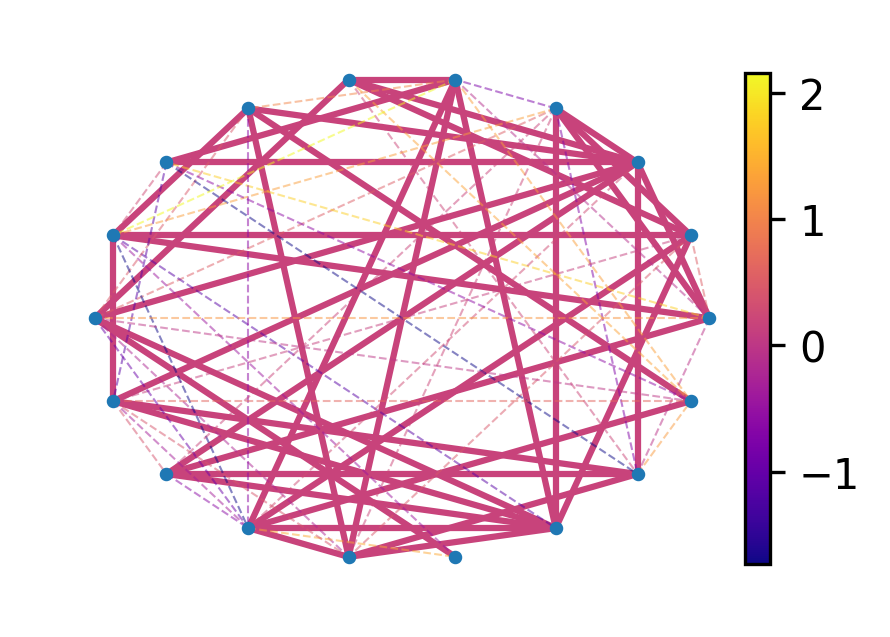

In [66]:
cmap=plt.cm.plasma
fig, ax = drawing_forex(lg_pred_mean, cmap)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=lg_pred_mean.min(), vmax=lg_pred_mean.max()))
# plot the colorbar
cbar = plt.colorbar(sm, ax=ax, shrink=0.85)
cax = cbar.ax  # get the ax of the colorbar
pos = cax.get_position()  # get the original position
cax.set_position([pos.x0*0.92, pos.y0, pos.width * 0.8, pos.height])  # set a new position
cax.set_frame_on(True)
cbar.ax.tick_params(labelsize=10)

NonHC case - matern 

/tmp/ipykernel_2289992/167837315.py:9: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos=nx.circular_layout(G), edgelist=test_edges, width=1.5, edge_color=y[test_ids], edge_cmap=cmap, edge_vmin=y.min(), edge_vmax=y.max(),)
/tmp/ipykernel_2289992/167837315.py:10: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos=nx.circular_layout(G), style='dashed', edgelist=train_edges, width=0.5, edge_color=y[train_ids], edge_cmap=cmap, edge_vmin=y.min(), edge_vmax=y.max(),alpha=0.5)


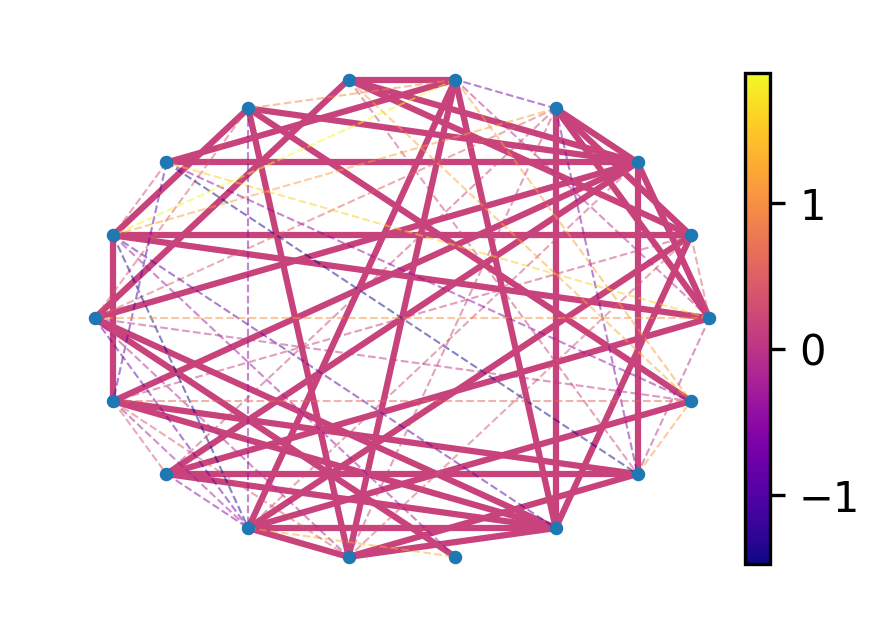

In [67]:
joint_pred_mean = np.load('../../results/forex/nonhc_pred_mean.npy', allow_pickle=True)

cmap=plt.cm.plasma
fig, ax = drawing_forex(joint_pred_mean, cmap)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=joint_pred_mean.min(), vmax=joint_pred_mean.max()))
# plot the colorbar
cbar = plt.colorbar(sm, ax=ax, shrink=0.85)
cax = cbar.ax  # get the ax of the colorbar
pos = cax.get_position()  # get the original position
cax.set_position([pos.x0*0.92, pos.y0, pos.width * 0.8, pos.height])  # set a new position
cax.set_frame_on(True)
cbar.ax.tick_params(labelsize=10)